<a href="https://colab.research.google.com/github/owenwang05/dish-detect/blob/main/feature_extraction_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Dish Detect:** Feature-extraction model

**End-to-end CNN Image Classification Model**

Feature extraction model based on EfficientNetB1 trained and evaluated on the Food101 Dataset

## Initial Setup

In [ ]:
# Check the GPU (must be T4 for mixed precision training)
!nvidia-smi

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Import required packages
import tensorflow as tf
print(tf.__version__)

In [ ]:
# Import addiitonal packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os
import tensorflow_datasets as tfds
import seaborn as sn

In [ ]:
# Import aelper functions
!wget https://raw.githubusercontent.com/gauravreddy08/deep-learning-tensorflow/main/extras/helper_function.py

In [ ]:
# Load helper functions
from helper_function import plot_loss_curves, load_and_prep_image

## Prepare Data

The dataset being used is Food101, which is available on TensorFlow

The dataset is imported using the `TensorFlow Datasets` module

In [ ]:
# Check if Food101 dataset is avaliable
datasets_list = tfds.list_builders()
print("food101" in datasets_list)

In [10]:
# Import data set
(train_data_initial, test_data_initial), ds_info = tfds.load(name='food101',
                                             split=['train', 'validation'],
                                             shuffle_files=False,
                                             as_supervised=True,
                                             with_info=True) # provides ds_info variable

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.4332PF_2.0.0/food101-train.tfrecord*...:   0%|         …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.4332PF_2.0.0/food101-validation.tfrecord*...:   0%|    …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [11]:
# Features of Food101 fomr TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [12]:
# Get class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [13]:
# Take on sample of the train data
train_data_sample = train_data_initial.take(1)
train_data_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [14]:
# Output info about the training sample
for image, label in train_data_sample:
  print(f"Image shape: {image.shape}")
  print(f"Image datatype: {image.dtype}")
  print(f"Target class from Food101: {class_names[label]}")

Image shape: (512, 512, 3)
Image datatype: <dtype: 'uint8'>
Target class from Food101: huevos_rancheros


(-0.5, 511.5, 511.5, -0.5)

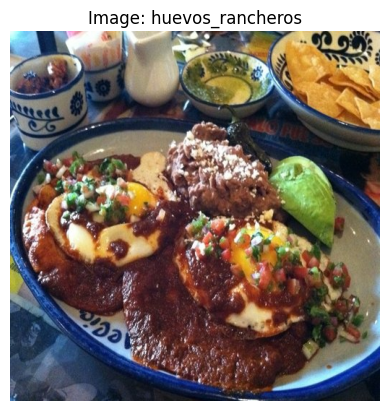

In [15]:
# Plot the image
plt.imshow(image)
plt.title(f"Image: {class_names[label]}")
plt.axis(False)

## Preprocess Data

Current Data
* `uint8` datatype
* Different sized tensors
* Unscaled (0-255)

Model Wants
* `float` datatype
* Same sized tensors
* Normailzied

In [16]:
# Create preprocessing function
def preprocess_img(image, label, img_size=224):
  image = tf.image.resize(image, [img_size, img_size])
  image = tf.cast(image, tf.float16)
  return image, label

In [17]:
# Test preprocessing function
preprocessed_img = preprocess_img(image, label)[0]
preprocessed_img

<tf.Tensor: shape=(224, 224, 3), dtype=float16, numpy=
array([[[230.6  , 253.6  , 251.   ],
        [223.   , 255.   , 252.2  ],
        [207.1  , 255.   , 250.4  ],
        ...,
        [140.6  , 129.5  , 121.25 ],
        [121.1  , 115.25 , 116.94 ],
        [ 83.94 ,  83.06 ,  89.6  ]],

       [[221.5  , 254.4  , 253.4  ],
        [214.5  , 255.   , 253.9  ],
        [198.4  , 254.6  , 252.   ],
        ...,
        [208.6  , 195.9  , 173.4  ],
        [197.   , 190.1  , 174.9  ],
        [175.5  , 171.6  , 161.2  ]],

       [[204.2  , 253.4  , 249.6  ],
        [198.8  , 254.6  , 251.2  ],
        [185.   , 251.8  , 252.2  ],
        ...,
        [222.5  , 207.5  , 169.4  ],
        [216.5  , 205.   , 172.   ],
        [215.5  , 207.9  , 177.6  ]],

       ...,

       [[ 47.12 ,  81.06 , 121.2  ],
        [ 30.4  ,  63.62 , 101.3  ],
        [127.4  , 158.9  , 193.   ],
        ...,
        [  3.953,  11.95 ,  23.38 ],
        [  2.27 ,  10.33 ,  21.22 ],
        [  6.863,  16.0

## Batch and Prepare Data

*   `Parallelize` - allows for parallel computing when mapping data to preprocess
*   `Buffer Size` - number of elements from which the next element is randomly picked
*   `Prefetch` - prepare second batch while computing patterns on current batch


In [18]:
train_data = train_data_initial.map(preprocess_img, tf.data.AUTOTUNE)
train_data = train_data.shuffle(buffer_size=1000).batch(32).prefetch(tf.data.AUTOTUNE)

test_data = test_data_initial.map(preprocess_img, tf.data.AUTOTUNE)
test_data = test_data.batch(32)

In [19]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float16, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [20]:
test_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float16, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [21]:
train_data_initial

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

## Create Data Augmentation Layer

In [22]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal"),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.2),
  tf.keras.layers.RandomHeight(0.2),
  tf.keras.layers.RandomWidth(0.2),
], name="data_augmentation")

## Create Modelling Callbacks

* `Model Checkpoint`- used to save checkpoints during training
* `Early Stopping` - used to stop training when a matric stops improving
* `ReduceLRonPlateau` - used to reduce LR when metric has stopped improving

In [23]:
# Model Checkpoint Callback
checkpoint_path = "model_checkpoints/cp.weights.h5"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True,
                                                         verbose=1)

In [24]:
# Early Stopping Callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(restore_best_weights=True,
                                                           patience=3,
                                                           verbose=1,
                                                           monitor="val_accuracy")

In [25]:
# ReduceLROnPlateau Callback
lower_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.2,
                                                monitor='val_accuracy',
                                                min_lr=1e-7,
                                                patience=0,
                                                verbose=1)

## Setup Mixed Precision Training

allows the model to use `16-bit` floating point numbers to read/write to memory faster

In [26]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy='mixed_float16')

In [27]:
mixed_precision.global_policy()

<DTypePolicy "mixed_float16">

## Build Model

In [28]:
# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False) # removed ouput layer

# Create input layer
inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")

# Create data augmentation layer
x = data_augmentation(inputs)

# Define functional layer
x = base_model(x, training=False) # maintains inference mode
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
x = tf.keras.layers.Dropout(.3)(x)

# Define output layer
x = tf.keras.layers.Dense(len(class_names))(x)
outputs = tf.keras.layers.Activation("softmax")(x)
model = tf.keras.Model(inputs, outputs)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [29]:
# Compile Model
model.compile(loss="sparse_categorical_crossentropy", # used because of output label shape (not one-hot encoded)
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=["accuracy"])

In [30]:
# Model Summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_augmentation (Sequential)       │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, None, None, 1280)    │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling_layer         │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 101)                 │         129,381 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 101)                 │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 4,136,929 (15.78 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [31]:
# Fit the Model
history = model.fit(train_data,
                    epochs=20,
                    validation_data=test_data,
                    validation_steps=int(0.15 * len(test_data)),
                    callbacks=[checkpoint_callback,
                               early_stopping_callback,
                               lower_lr])

2368/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 657ms/step - accuracy: 0.3831 - loss: 2.5770
Epoch 1: val_accuracy improved from -inf to 0.57918, saving model to model_checkpoints/cp.weights.h5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 1615s 661ms/step - accuracy: 0.3831 - loss: 2.5767 - val_accuracy: 0.5792 - val_loss: 1.5984 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 1.


## Evaluate Model
*`loss curves` -

*`confusion matrix`

*`f1 scores`


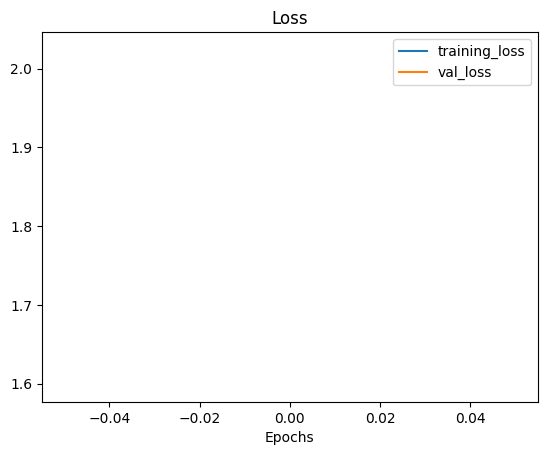

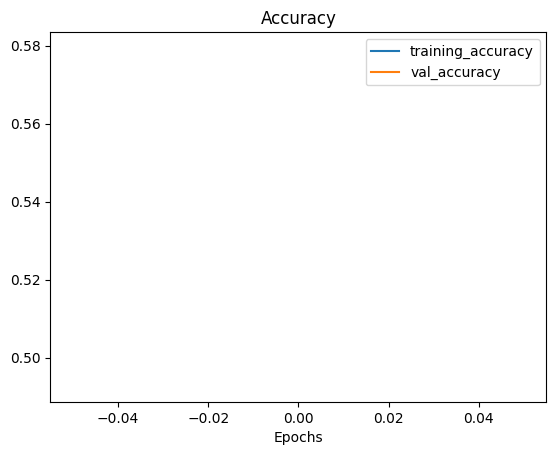

In [32]:
plot_loss_curves(history)

In [33]:
model.evaluate(test_data)

790/790 ━━━━━━━━━━━━━━━━━━━━ 47s 60ms/step - accuracy: 0.5801 - loss: 1.5954


[1.5972462892532349, 0.5788910984992981]

In [34]:
# Get Probability Matrix
pred_probs = model.predict(test_data, verbose=1)
len(pred_probs), pred_probs.shape

790/790 ━━━━━━━━━━━━━━━━━━━━ 46s 55ms/step


(25250, (25250, 101))

In [35]:
# Get Prediciton
pred_classes = pred_probs.argmax(axis=1)
pred_classes[:10], len(pred_classes), pred_classes.shape

(array([29, 41, 91, 53, 97, 31, 10, 31,  5,  8]), 25250, (25250,))

In [36]:
# Getting true labels for the test_data
y_labels = []
test_images = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy())
y_labels[:10]

[29, 81, 91, 53, 97, 97, 10, 31, 3, 100]

In [37]:
# Compute Accuracy Score
from sklearn.metrics import accuracy_score

sklearn_acc = accuracy_score(y_labels, pred_classes)
sklearn_acc

0.5788910891089109

In [38]:
# Create confusion matrix
cm = tf.math.confusion_matrix(y_labels, pred_classes)

plt.figure(figsize = (200, 200));
sn.heatmap(cm, annot=True,
           fmt='',
           cmap='Blues');

In [39]:
# Plot F1 Scores

## Save and Export Model

In [40]:
# Saving the model
model.save("/content/drive/My Drive/FinalModel.hdf5")

TypeError: cannot pickle 'module' object

In [ ]:
# Saving the model
model.save("FoodVision.hdf5")